# Plotting GFDL Ocean model output
by Andrew Shao (andrew.shao@noaa.gov) June 2016

Visualizing model output is one of the key ways that we can try to understand the results of model runs. This notebook covers some basics of how numerical modeling in general works and provides examples of the different types of plots that are commonly used to understand the model output.

## What is a general circulation model

Mathematical modeling shows up in almost every field and in general refers to the practice of representing a system using mathematical equations. This can range from simple physics (for example projectile motion) to models of extraordinary complexity. Even for very simple systems, these equations cannot be solved directly and/or the system being modeled is so large that it is not practical to work out the solution by hand. Climate models, like the ones developed here at GFDL, fall into this category. Climate models must take into account biology, chemistry, and physics in a variety of different types of domains like the atmosphere, ocean, ice, and land.

Numerical modeling relies on breaking a continuous system into a discrete grid. For general circulation of the ocean (or similarly the atmosphere), we divided the ocean into cubes. We then use equations which describe how different forces acting on each cube will either lead water to accelerate or change properties within the cube (e.g. temperature, salinity) and also the neighboring cubes. 

The cubes we use in a GCM are oriented vertically and horizontally. The vertical direction is often (though not always) depth, how far away from the surface of the ocean, or pressure, how much water is above the cube. The north-south direction is referred to as the meridional direction because aligns with the lines of longitude (or meridians). The east-west direction is in the same direction as lines of latitude and is referred to as the zonal direction (not sure why). Model resolution often refers to the horizontal dimensions of these cubes. For example if we refer to a 1-degree model, that means that a typical model 'cube' spans 1 degree of latitude (about 110km) and 1 degree of longitude. 

As an example of why we need computers to solve this, consider that the ocean component of ESM2M (a GFDL climate model) discretized the ocean into 210x360 boxes horizontally and 50 vertically.


In [1]:
print("Number of Cubes: %d" % (210*360*50))

Number of Cubes: 3780000


Even just summing up one number would take a ridiculous amount of time by hand. However, these kind of repeated computations are exactly the kind of thing that computers do best.

“It is unworthy of excellent men to lose hours like slaves in the labour of calculation which could safely be relegated to anyone else if machines were used."-Gottfried Leibniz, co-discover of calculus

# Plotting model output spatially
MOM6 is the next-generation ocean model under active development here at GFDL. Some configurations of the model are at 1/4$^\circ$ degree. Let's take a look at the horizontal grid of one of the. We'll also use this as an opportunity to learn how to manipulate netCDF files (a data storage format), matplotlib, and basemap. 

In [2]:
import netCDF4 as nc # Data storage routines
import numpy as np # Mathematical toolbox
import matplotlib.pyplot as plt # Basic python plotting routines
from mpl_toolkits.basemap import Basemap # Geospatial plotting

%matplotlib inline

The first thing to recognize when plotting model output is a classic problem: there's no way to take a map of the world and fold into a sphere. The Earth is a sphere (3d and curvy), computer screens and paper are not (2d and flat). So to visualize global data, we have to "project" quantities from a sphere to a screen. Using a projection always involves some compromise between preserving distance, area, or shape. The Mercator projection is a good example of this.

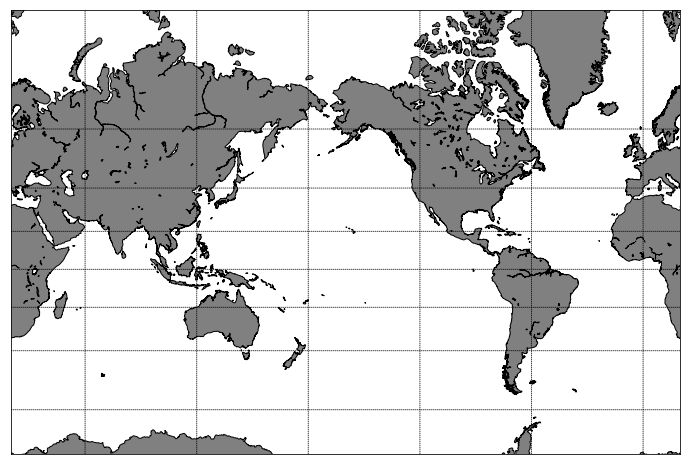

In [3]:
plt.figure(figsize=(12,12))
m = Basemap(projection='merc',llcrnrlat=-70,urcrnrlat=80,\
            llcrnrlon=20,urcrnrlon=380,lat_ts=20,resolution='l')
m.drawcoastlines();
m.fillcontinents(color='gray');
m.drawparallels(np.arange(-80.,80.,20.));
m.drawmeridians(np.arange(-180.,181.,60.));

Greenland is huge, about the size of Africa whereas in actuality Africa is 15x larger than Greenland. Alaska looks about as big as the United States. Eckert IV is a different projection that does a little bit of a better job of representing both distance and area

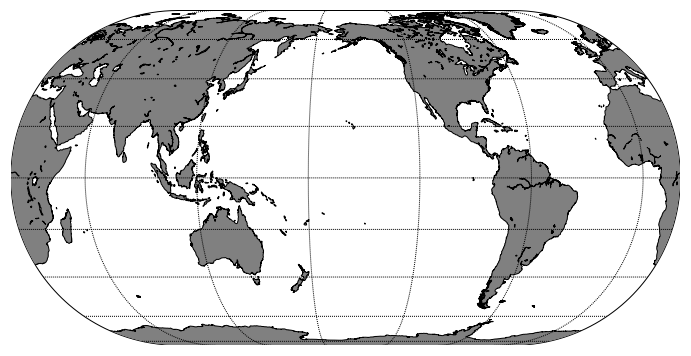

In [4]:
plt.figure(figsize=(12,12))
m = Basemap(projection='eck4',lon_0=(20+380)/2,resolution='l')
m.drawcoastlines();
m.fillcontinents(color='gray');
m.drawparallels(np.arange(-80.,80.,20.));
m.drawmeridians(np.arange(-180.,181.,60.));

### The horizontal grid
The boxes that make up a model 'grid' are not necessarily equally spaced. The GFDL ocean models use what's known as a tripolar grid to avoid the problem that distances go to zero in latitude/longitude space at the north pole. Also, there's finer resolution near the equator to make dynamical features (like tropical instability waves) are resolved. Here, a subset of the horizontal grid will be plotted to demonstrate how to plot geospatially referenced data. Each dot represents 10 grid cells in each direction. Note that the dots are not uniformly spaced. 

In [5]:
# Uncomment and run this block of code if you haven't downloaded the example data
#from urllib.request import urlretrieve
#urlretrieve('ftp://ftp.gfdl.noaa.gov/pub/Andrew.Shao/PythonSeminar/MOM6_example_output.nc',
#            'MOM6_example_output.nc')
#filepath = 'MOM6_example_output.nc'

In [6]:
# Uncomment this line and set the path to where you downloaded the example data
filepath = '/local2/home/model_output/python-seminar/MOM6_example_output.nc'

In [7]:
geolat = nc.Dataset(filepath).variables['geolat'][:,:] # 2D array of latitudes
geolon = nc.Dataset(filepath).variables['geolon'][:,:] # 2D array of longitudes

NameError: name 'filepath' is not defined

In [ ]:
nstride = 10 # How much to decimate the grid

plt.figure(figsize=(12,12))
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-300,urcrnrlon=60,lat_ts=20,resolution='c')
m.drawcoastlines();
m.drawparallels(np.arange(-80.,80.,20.));
m.drawmeridians(np.arange(-180.,181.,60.));

mapx,mapy = m(geolon,geolat)
m.scatter(mapx[::nstride,::nstride],mapy[::nstride,::nstride]);

### Plotting variables on surfaces

Using what we now know about the model grid, we'll plot sea surface temperature two different ways, one as a pcolor and one as a contour plot using output from MOM6. As we saw before, there are an incredible amount of model points that in just the ocean model alone. To store one variable (like temperature) at one timestamp for the ESM2M model takes  It's thus good practice to only extract the parts of the data that you'll actually need. In this example, we'll only extract temperature at the first level (the surface).

In [ ]:
tidx = 0
layidx = 0
geolat = nc.Dataset(filepath).variables['geolat'][:,:]
geolon = nc.Dataset(filepath).variables['geolon'][:,:]
temp = np.squeeze(nc.Dataset(filepath).variables['thetao'][tidx,layidx,:,:])

#### Pseudocolor map
A pseudo colormap produces a plot where each model box is colored by the value of the variable in that box and the colormap being used. Matplotlib has a number of good colormaps for generic use, but there's also a http://matplotlib.org/cmocean/ which have colormaps specifically designed for oceanographic variables (though these are in no way standardized).

In [ ]:
plt.figure(figsize=(12,6))
m = Basemap(projection='eck4',lon_0=(-300+60)/2,resolution='c')
mapx,mapy = m(geolon,geolat)
m.drawcoastlines();
m.fillcontinents(color='gray');
m.drawparallels(np.arange(-90.,91.,30.));
m.drawmeridians(np.arange(-180.,181.,60.));

m.pcolormesh(mapx,mapy,temp);

cax = plt.colorbar()
cax.set_label('Temperature')
plt.title('Layer %d' % (layidx+1));

Pcolor plots are the most accurate representation of the model variable since each grid point gets its own value. However, it is difficult to pick out the exact value of any given point and smaller changes are sometimes harder to see by eye. In these cases, contour plots are sometimes preferred.

In [ ]:
plt.figure(figsize=(12,6))
m = Basemap(projection='eck4',lon_0=(-300+60)/2,resolution='c')
mapx,mapy = m(geolon,geolat)
m.drawcoastlines();
m.fillcontinents(color='gray');
m.drawparallels(np.arange(-90.,91.,30.));
m.drawmeridians(np.arange(-180.,181.,60.));

m.contourf(mapx,mapy,temp);

cax = plt.colorbar()
cax.set_label('Temperature')
plt.title('Layer %d' % (layidx+1));

In [ ]:
plt.figure(figsize=(12,12))
m = Basemap(projection='npaeqd',boundinglat=60,lon_0=-120,resolution='l')
mapx,mapy = m(geolon,geolat)
m.drawcoastlines();
m.fillcontinents(color='gray');
m.drawparallels(np.arange(60.,91.,10.));
m.drawmeridians(np.arange(-180.,181.,60.));
cf = m.contourf(mapx,mapy,temp,np.arange(-2,4.1,1),cmap=plt.cm.Spectral)
cax = plt.colorbar(cf)
cax.set_label('Temperature')

### Transects
Spatial maps of a variable are useful because they show how things change globally. However, the ocean changes dramatically with depth as well. Additionally, many of the observations of properties in the ocean occur along hydrographic transects (slices) which are usually oriented meridionally or vertically. An atlas of these measurements taken during World Ocean Circulation Experiment are available for all the oceans. The Pacific one is located here: http://www-pord.ucsd.edu/whp_atlas/pacific/sections.htm

#### Zonal Transect (Depth-Longitude)
In this section we'll make of plot of salinity along a zonal transect at 30N to compare the WOCE line P02 http://www-pord.ucsd.edu/whp_atlas/pacific/p02/sections/ctd/2500/P02_CTDSAL_upper_2500.jpg

We'll use the 'yh' variable to find the data index along the latitude dimension closest to 30$^\circ$N.

In [ ]:
tidx = 0
plotlat = 30
lat = nc.Dataset(filepath).variables['yh'][:]
lon = nc.Dataset(filepath).variables['xh'][:]
depth = nc.Dataset(filepath).variables['z_l'][:]
latidx = np.argmin(np.abs(lat-plotlat))
temp = np.squeeze(nc.Dataset(filepath).variables['so'][tidx,:,latidx,:])


In [ ]:
plt.figure(figsize=(12,4))
plt.pcolormesh(lon,depth,temp,vmin=34,vmax=34.9,cmap=plt.cm.YlGnBu_r)
plt.xlim(-240, -110)
plt.ylim(0,1000)
plt.gca().invert_yaxis()
cax = plt.colorbar()
cax.set_label('Salinity')

#### Meridional Transect (Depth-Latitude)
Making a meridional transect is similar to that of a zonal transect, except that we're slicing the variable along the longitude dimension. In this example, we'll take it along 150$^\circ$W and compare against WOCE P16 (http://www-pord.ucsd.edu/whp_atlas/pacific/p16/sections/ctd/2500/P16_CTDSAL_all_1000.jpg)

In [ ]:
tidx = 0
plotlon = -150
lat = nc.Dataset(filepath).variables['yh'][:]
lon = nc.Dataset(filepath).variables['xh'][:]
lonidx = np.argmin(np.abs(lon-plotlon))

temp = np.squeeze(nc.Dataset(filepath).variables['so'][tidx,:,:,lonidx])

In [ ]:
plt.figure(figsize=(12,4))
plt.pcolormesh(lat,depth,temp,vmin=34,vmax=34.9,cmap=plt.cm.YlGnBu_r)
plt.xlim(-60, 60)
plt.ylim(0,5000)
plt.gca().invert_yaxis()
cax = plt.colorbar()
cax.set_label('Salinity')